# Hartree-Fock Code for the H2 Molecule in a Minimal STO-3G basis

The following notebook will attempt to follow along with the model H$_{2}$ calculations in Szabo and Ostlund section 3.5.


1. Setup system - position molecule and define basis
2. Define coefficient matrix, $\mathbf{C}$, and compute density matrix, $\mathbf{P}$.
3. Compute $\mathbf{S}$, $\mathbf{H_{core}} = \mathbf{T} + \mathbf{V}$ and two-electron integrals.
4. Populate the two-electron matrix, $\mathbf{G}$, and then compute the Fock matrix $\mathbf{F} = \mathbf{H_{core}} + \mathbf{G}$
5. Diagonalize $\mathbf{S}^{-1}\mathbf{F}$ to obtain orbital energies
6. Compute total energy

## Subroutines

In [34]:
# load some libraries
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
%matplotlib inline

### Basis Function Overlap Calculation

For this calculation we are using and STO-3G minimal basis for H2.  This means there are two basis functions of the form

$\phi_i(r) = \sum_{k=1}^{3} g_{i,k}\phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A})$

where $\mathbf{R_A}$ (typically an atomic nucleus) is the center of the primitive gaussian given by

$\phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) = \left(\frac{2\alpha_{i,k}}{\pi}\right)^{3/4}e^{-\alpha_{i,k} (\mathbf{r}-\mathbf{R_A})^2}$.

The basis set overlap integral is given by

$S_{ij} = \langle \phi_i | \phi_j \rangle  = \langle\sum_{k=1}^{3} g_{i,k}\phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) | \sum_{l=1}^{3} g_{j,l}\phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B})\rangle $

$ = \sum_{k,l} g_{i,k}g_{j,l} \langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) | \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle $.

Thus we must determine the form of the primitive gaussian integral

$\langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) | \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle  = \left(\frac{2}{\pi}\right)^{1.5}\left(\alpha_{i,k}\alpha_{j,l}\right)^{3/4}\int e^{-\alpha_{i,k} (\mathbf{r}-\mathbf{R_A})^2} e^{-\alpha_{j,l} (\mathbf{r}-\mathbf{R_B})^2} d\mathbf{r}$

The integral on the right-hand side is of the product of two gaussian functions.  Recall that the product of two-gaussians is itself a new gaussian.  Namely:

$\int e^{-\alpha_{i,k} (\mathbf{r}-\mathbf{R_A})^2} e^{-\alpha_{j,l} (\mathbf{r}-\mathbf{R_B})^2} d\mathbf{r} = K \int e^{-p(\mathbf{r}-\mathbf{R_p})^2}\mathbf{r}$

where K is a constant (known form),

$R_p = \frac{\alpha_{i,k}\mathbf{R_A}+\alpha_{j,l}\mathbf{R_B}}{\alpha_{i,k}+\alpha_{j,l}}$

and 

$ p = \alpha_{i,k}+\alpha_{j,l}$.

It can be shown that this ultimately yields

$\langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) | \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle  = \left(\alpha_{i,k}\alpha_{j,l}\right)^{3/4} \left( \frac{2}{\alpha_{i,k}+\alpha_{j,l}}\right)^{1.5}e^{-\alpha_{i,k}\alpha_{j,l}/(\alpha_{i,k}+\alpha_{j,l})(\mathbf{R_A}-\mathbf{R_B})^2}$

Thus we get for STO-3G Hydrogen 1s basis:

$S_{ij} = \sum_{k,l} g_{i,k}g_{j,l}\left(\alpha_{i,k}\alpha_{j,l}\right)^{3/4} \left( \frac{2}{\alpha_{i,k}+\alpha_{j,l}}\right)^{1.5}e^{-\alpha_{i,k}\alpha_{j,l}/(\alpha_{i,k}+\alpha_{j,l})(\mathbf{R_A}-\mathbf{R_B})^2}$

In [35]:
def basis_overlap(alpha,dA,RA,beta,dB,RB):
    overlap = 0.0
    for i in range(len(alpha)):
        for j in range(len(beta)):
            overlap += alpha[i]**0.75*beta[j]**0.75*dA[i]*dB[j]*gaussian_overlap(alpha[i],RA,beta[j],RB)
    return overlap*(2.0)**1.5

def gaussian_overlap(alpha, RA, beta, RB):
    prefactor = ((alpha+beta))**(-1.5)
    diff = RA - RB
    dist2 = np.dot(diff,diff)
    return prefactor*np.exp(-alpha*beta/(alpha+beta)*dist2)    

### Kinetic Energy Matrix Elements

For the kinetic energy matrix element

$T_{ij} = \langle \phi_i | -0.5\nabla^2| \phi_j \rangle  = \langle\sum_{k=1}^{3} g_{i,k}\phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) | -0.5\nabla^2| \sum_{l=1}^{3} g_{j,l}\phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B})\rangle $

$ = \sum_{k,l} -0.5 g_{i,k}g_{j,l}\langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) |\nabla^2| \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle$

Thus we examine the primitive gaussian term

$\langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) |\nabla^2| \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle = \left(\frac{2}{\pi}\right)^{1.5}\left(\alpha_{i,k}\alpha_{j,l}\right)^{3/4} \int e^{-\alpha_{i,k} (\mathbf{r}-\mathbf{R_A})^2} \nabla^2 e^{-\alpha_{j,l} (\mathbf{r}-\mathbf{R_B})^2} d\mathbf{r}$

$ = \left(\frac{2}{\pi}\right)^{1.5}\left(\alpha_{i,k}\alpha_{j,l}\right)^{3/4}\frac{\alpha_{i,k}\alpha_{j,l}}{\alpha_{i,k}+\alpha_{j,l}} \left[ 3 - 2\alpha_{i,k}\alpha_{j,l}/(\alpha_{i,k}+\alpha_{j,l}) (\mathbf{R_A}-\mathbf{R_B})^2\right] [\pi/(\alpha_{i,k}+\alpha_{j,l})]^{3/2}e^{-\alpha_{i,k}\alpha_{j,l}/(\alpha_{i,k}+\alpha_{j,l}) (\mathbf{R_A}-\mathbf{R_B})^2}$

provided here without derivation.  See Ostlund and Szabo Page 412 for the derivation.

In [40]:
def basis_kinetic(alpha,dA,RA,beta,dB,RB):
    kinetic = 0.0
    for i in range(len(alpha)):
        for j in range(len(beta)):
            kinetic += (alpha[i]*beta[j])**0.75*dA[i]*dB[j]*gaussian_kinetic(alpha[i],RA,beta[j],RB)
    return kinetic*(2.0/np.pi)**1.5

def gaussian_kinetic(alpha, RA, beta, RB):
    AplusB = alpha + beta
    diff = RA - RB
    dist2 = np.dot(diff,diff)
    prefactor = alpha*beta/AplusB*(3-2*alpha*beta/AplusB*dist2)*(np.pi/AplusB)**1.5
    return prefactor*np.exp(-alpha*beta/AplusB*dist2)

### One-electron Potential Energy Matrix Elements

For the one-electron potential energy matrix element

$V_{ij} = \langle \phi_i | -\sum_C\frac{Z_C}{|\mathbf{r}-\mathbf{R_C}|}| \phi_j \rangle  = \langle\sum_{k=1}^{3} g_{i,k}\phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) | -\sum_C\frac{Z_C}{|\mathbf{r}-\mathbf{R_C}|}| \sum_{l=1}^{3} g_{j,l}\phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B})\rangle $

$ = -\sum_{k,l,C} g_{i,k}g_{j,l}\langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) |\frac{Z_C}{|\mathbf{r}-\mathbf{R_C}|}| \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle$

Thus we examine the primitive gaussian term

$\langle \phi^{GF}_{1s}(\alpha_{i,k},\mathbf{r}-\mathbf{R_A}) |\frac{Z_C}{|\mathbf{r}-\mathbf{R_C}|}| \phi^{GF}_{1s}(\alpha_{j,l},\mathbf{r}-\mathbf{R_B}) \rangle = Z_C\left(\frac{2}{\pi}\right)^{1.5}\left(\alpha_{i,k}\alpha_{j,l}\right)^{3/4} \int e^{-\alpha_{i,k} (\mathbf{r}-\mathbf{R_A})^2}\frac{1}{|\mathbf{r}-\mathbf{R_C}|} e^{-\alpha_{j,l} (\mathbf{r}-\mathbf{R_B})^2} d\mathbf{r}$

$ = \frac{-2\pi Z_C}{\alpha_{i,k} + \alpha_{j,l}}\exp\left[\frac{-\alpha_{i,k}\alpha_{j,l}}{\alpha_{i,k} + \alpha_{j,l}} |\mathbf{R_A} - \mathbf{R_B}|^2\right]\frac{1}{2}\sqrt{\frac{\pi}{p|\mathbf{R_P}-\mathbf{R_C}|^2}}erf(p^{1/2}|\mathbf{R_P}-\mathbf{R_C}|)$

provided here without derivation.  See Ostlund and Szabo Page 413-414 for the derivation.

In [5]:
def basis_potential(alpha,dA,RA,beta,dB,RB,Z,R):
    potential = 0.0
    nAtoms = len(Z)
    for atom in range(nAtoms):
        for i in range(len(alpha)):
            for j in range(len(beta)):
                prefactor = -Z[atom]*(2.0/np.pi)**1.5*(alpha[i]*beta[j])**0.75*dA[i]*dB[j]
                potential += prefactor*gaussian_erf(alpha[i],RA,beta[j],RB,R[atom,:])
    return potential

def gaussian_erf(alpha, RA, beta, RB, RC):
    AplusB = alpha + beta
    RP = (alpha*RA+beta*RB)/AplusB
    RPminusRC = RP - RC
    RPRC2 = np.dot(RPminusRC,RPminusRC)
    RAminusRB = RA - RB
    RARB2 = np.dot(RAminusRB,RAminusRB)
    if (RPRC2 == 0 and RARB2 ==0):
        return 2.0*np.pi/AplusB
    else:
        t = np.sqrt(AplusB*RPRC2)
        prefactor = 2.0*np.pi*0.5/AplusB*np.sqrt(np.pi)/t*erf(t)
        return prefactor*np.exp(-alpha*beta/AplusB*RARB2)

### Two-electron Integrals

For the one-electron potential energy matrix element

$\langle \mu\nu | \frac{1}{|\mathbf{r}_{12}|}| \lambda\sigma \rangle= \langle \phi_\mu \phi_\nu| \frac{1}{|\mathbf{r}_{12}|}| \phi_\lambda\phi_\sigma \rangle  = \langle\sum_{i=1}^{3} g_{\mu,i}\phi^{GF}_{1s}(\alpha_{\mu,i},\mathbf{r}-\mathbf{R_A})\sum_{j=1}^{3} g_{\nu,j}\phi^{GF}_{1s}(\alpha_{\nu,j},\mathbf{r}-\mathbf{R_B}) | \frac{1}{|\mathbf{r}_{12}|}| \sum_{k=1}^{3} g_{\lambda,k}\phi^{GF}_{1s}(\alpha_{\lambda,k},\mathbf{r}-\mathbf{R_C})\sum_{l=1}^{3} g_{\sigma,l}\phi^{GF}_{1s}(\alpha_{\sigma,l},\mathbf{r}-\mathbf{R_D})\rangle $

$ = \sum_{i,j,k,l} g_{\mu,i}g_{\nu,j}g_{\lambda,k}g_{\sigma,l}\langle \phi^{GF}_{1s}(\alpha_{\mu,i},\mathbf{r}-\mathbf{R_A}) \phi^{GF}_{1s}(\alpha_{\nu,j},\mathbf{r}-\mathbf{R_B})|\frac{1}{|\mathbf{r}_{12}|}| \phi^{GF}_{1s}(\alpha_{\lambda,k},\mathbf{r}-\mathbf{R_C}) \phi^{GF}_{1s}(\alpha_{\sigma,l},\mathbf{r}-\mathbf{R_D})\rangle$

Thus we examine the primitive gaussian term

$\langle \phi^{GF}_{1s}(\alpha_{\mu,i},\mathbf{r}-\mathbf{R_A}) \phi^{GF}_{1s}(\alpha_{\nu,j},\mathbf{r}-\mathbf{R_B})|\frac{1}{|\mathbf{r}_{12}|}| \phi^{GF}_{1s}(\alpha_{\lambda,k},\mathbf{r}-\mathbf{R_C}) \phi^{GF}_{1s}(\alpha_{\sigma,l},\mathbf{r}-\mathbf{R_D})\rangle $

$ = \frac{2\pi^{5/2}}{(\alpha_{\mu,i}+\alpha_{\nu,j}) (\alpha_{\lambda,k}+\alpha_{\sigma,l}) (\alpha_{\mu,i}+\alpha_{\nu,j} + \alpha_{\lambda,k}+\alpha_{\sigma,l})^{1/2}} \exp\left[ \frac{-\alpha_{\mu,i}\alpha_{\nu,j}}{\alpha_{\mu,i}+\alpha_{\nu,j}} |\mathbf{R}_A-\mathbf{R}_B|^2 -\frac{\alpha_{\lambda,k}\alpha_{\sigma,l}}{\alpha_{\lambda,k}+\alpha_{\sigma,l}} |\mathbf{R}_C-\mathbf{R}_D|^2  \right]F_0\left[ \frac{(\alpha_{\mu,i}+\alpha_{\nu,j}) (\alpha_{\lambda,k}+\alpha_{\sigma,l})}{(\alpha_{\mu,i}+\alpha_{\nu,j} + \alpha_{\lambda,k}+\alpha_{\sigma,l})}|\mathbf{R}_P-\mathbf{R}_Q|^2 \right]$

provided here without derivation.  See Ostlund and Szabo Page 415-416 for the derivation.

In [44]:
# two electron integrals
def basis_2e(alpha,dA,RA,beta,dB,RB,gamma,dC,RC,delta,dD,RD):
    twoE = 0.0
    for i in range(len(alpha)):
        for j in range(len(beta)):
            for k in range(len(gamma)):
                for l in range(len(delta)):
                    prefactor = (alpha[i]*beta[j]*gamma[k]*delta[l])**0.75*dA[i]*dB[j]*dC[k]*dD[l]
                    twoE += prefactor*gaussian_2e(alpha[i],RA,beta[j],RB,gamma[k],RC,delta[l],RD)
    return twoE*(2.0/np.pi)**3  

def gaussian_2e(alpha,RA,beta,RB,gamma,RC,delta,RD):
    AplusB = alpha + beta
    # weighted average of RA and RB
    RP = (alpha*RA+beta*RB)/AplusB
    GplusD = gamma + delta
    # weighted average of RC and RD
    RQ = (gamma*RC+delta*RD)/GplusD
    RAminusRB = RA - RB
    RARB2 = np.dot(RAminusRB,RAminusRB)
    RCminusRD = RC - RD
    RCRD2 = np.dot(RCminusRD,RCminusRD)
    RPminusRQ = RP - RQ
    RPRQ2 = np.dot(RPminusRQ,RPminusRQ)
    denom = AplusB*GplusD*np.sqrt(AplusB+GplusD)
    prefactor = 2.0*np.pi**2.5/denom
    t = np.sqrt(AplusB*GplusD/(AplusB+GplusD)*RPRQ2)
    if (RPRQ2 !=0):
        prefactor *= 0.5*np.sqrt(np.pi)/t*erf(t)
    return prefactor*np.exp( -alpha*beta/AplusB*RARB2 - gamma*delta/GplusD*RCRD2)
    

In [45]:
def constructDensityMat(C):
    M = C.shape[0]
    P = np.zeros((M,M),dtype=float)
    for i in range(M):
        for j in range(i,M):
            for a in range(M//2):
                P[i,j] += C[i,a]*C[j,a]
            P[i,j] *= 2.0
            P[j,i] = P[i,j]
    return P

## Main Program

In [36]:
# define some system parameters
Z = np.array([1,1])    # nuclear charge in electron charge units
M = 2                  # number of basis functions

In [37]:
# set STO-3G basis for zeta = 1.24
alpha = np.array([0.168856,0.623913,3.42525])
d = np.array([0.444635,0.535328,0.154329])
R = np.empty((2,3),dtype=float)
R[0,0] = R[0,1] = R[0,2] = 0.0
R[1,0] = 1.4
R[1,1] = R[1,2] = 0.0

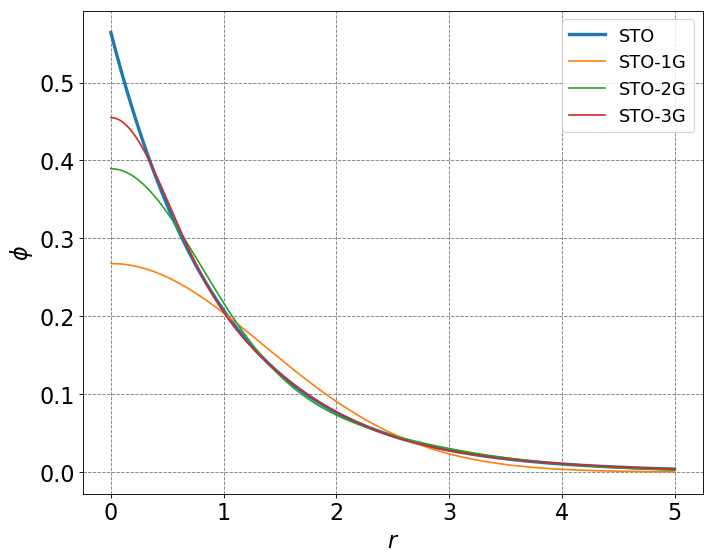

In [38]:
# plot basis function and compare to STO
# define function for making figures
def define_figure(xlabel="X",ylabel="Y"):
    # setup plot parameters
    fig = plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    ax.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    plt.tick_params(axis='both',labelsize=20)
    return ax
# define the radially symmetric slater type orbitals
def sto(n,zeta,r):
    f =  np.sqrt(zeta**3/np.pi)*np.exp(-zeta*r)
    return f 
# approximation of STO with n gaussians
def sto_ng(n,alpha,d,r):
    g = 0.0
    for i in range(n):
        g += d[i]*(2*alpha[i]/np.pi)**0.75*np.exp(-alpha[i]*r*r)
    return g 
# initialize a figure
ax = define_figure(xlabel="$r$",ylabel="$\phi$")
r = np.arange(0,5,0.001)
alphaSTO1G = [0.270950]
alphaSTO2G = [0.151623,0.851819]
dSTO2G = [0.678914,0.430129]
alphaSTO3G = [0.109818,0.405771,2.22766]
dSTO3G = [0.444635,0.535328,0.154329]
ax.plot(r,sto(1,1,r),lw=3,label="STO")
ax.plot(r,sto_ng(1,alphaSTO1G,[1.0],r),label="STO-1G")
ax.plot(r,sto_ng(2,alphaSTO2G,dSTO2G,r),label="STO-2G")
ax.plot(r,sto_ng(3,alphaSTO3G,dSTO3G,r),label="STO-3G")
plt.legend(fontsize=16)

In [39]:
# compute S, the overlap matrix
S = np.empty((M,M),dtype=float)
for i in range(M):
    for j in range(M):
        S[i,j] = basis_overlap(alpha,d,R[i,:],alpha,d,R[j,:])
Sinv = np.linalg.inv(S)
print(S)

[[1.00000134 0.65931916]
 [0.65931916 1.00000134]]


Here we dictate the coefficient matrix, $\mathbf{C}$, and then compute the density matrix, $\mathbf{P}$.  The density matrix is given as

$P_{\mu\nu} = 2\sum_{a}^{N/2}C_{\mu a}C^*_{\nu a}$.

In [46]:
# basis set coefficient matrix
C = np.empty((M,M),dtype=float)
# in this case we know the answer so can set it to be
C[0,0] = 1.0/np.sqrt(2*(1+S[0,1]))
C[0,1] = 1.0/np.sqrt(2*(1-S[0,1]))
C[1,0] = C[0,0]
C[1,1] = -C[0,1]
P = constructDensityMat(C)
print(P)

[[0.60265682 0.60265682]
 [0.60265682 0.60265682]]


In [41]:
# compute T, the kinetic energy matrix
T = np.empty((M,M),dtype=float)
for i in range(M):
    for j in range(M):
        T[i,j] = basis_kinetic(alpha,d,R[i,:],alpha,d,R[j,:])
print(T)

[[0.76003235 0.23645527]
 [0.23645527 0.76003235]]


In [42]:
# compute V, the potential energy matrix
V = np.empty((M,M),dtype=float)
for i in range(M):
    for j in range(M):
        V[i,j] = basis_potential(alpha,d,R[i,:],alpha,d,R[j,:],Z,R)
print(V)

[[-1.88044303 -1.19483649]
 [-1.19483649 -1.88044303]]


In [43]:
# save H-core
Hcore = T + V
print(Hcore)

[[-1.12041067 -0.95838123]
 [-0.95838123 -1.12041067]]


In [47]:
# Compute and save all two-electron integrals
twoE = np.empty((M,M,M,M),dtype=float)
for i in range(M):
    for j in range(M):
        for k in range(M):
            for l in range(M):
                twoE[i,j,k,l] = basis_2e(alpha,d,R[i,:],alpha,d,R[j,:],alpha,d,R[k,:],alpha,d,R[l,:])
                print("<",i+1,j+1,"|1/r12|",k+1,l+1,">=",twoE[i,j,k,l])

< 1 1 |1/r12| 1 1 >= 0.7746079055149173
< 1 1 |1/r12| 1 2 >= 0.44410895821293
< 1 1 |1/r12| 2 1 >= 0.44410895821292995
< 1 1 |1/r12| 2 2 >= 0.5696774985883132
< 1 2 |1/r12| 1 1 >= 0.4441089582129298
< 1 2 |1/r12| 1 2 >= 0.29702949599279366
< 1 2 |1/r12| 2 1 >= 0.2970294959927937
< 1 2 |1/r12| 2 2 >= 0.4441089582129301
< 2 1 |1/r12| 1 1 >= 0.4441089582129301
< 2 1 |1/r12| 1 2 >= 0.29702949599279366
< 2 1 |1/r12| 2 1 >= 0.29702949599279366
< 2 1 |1/r12| 2 2 >= 0.4441089582129298
< 2 2 |1/r12| 1 1 >= 0.5696774985883132
< 2 2 |1/r12| 1 2 >= 0.44410895821292995
< 2 2 |1/r12| 2 1 >= 0.44410895821293
< 2 2 |1/r12| 2 2 >= 0.7746079055149173


The two electron matrix, $\mathbf{G}$, has the form:

$G_{\mu\nu} = \sum_{\lambda\sigma}P_{\mu\nu}\left(\langle \mu\nu |\frac{1}{r_{12}}| \lambda\sigma\rangle - \langle \mu\lambda |\frac{1}{r_{12}}| \sigma\nu \rangle \right)$

In [48]:
# populate G matrix using two-electron integrals and density matrix
G = np.zeros((M,M),dtype=float)

for i in range(M):
    for j in range(M):
        G[i,j] = 0.0
        for k in range(M):
            for l in range(M):
                G[i,j] += P[k,l]*(twoE[i,j,l,k]-0.5*twoE[i,k,l,j])
print(G)

[[0.75487326 0.36449555]
 [0.36449555 0.75487326]]


In [49]:
F = Hcore + G

e,v = np.linalg.eig(np.dot(Sinv,F))

print(e)

[-0.5782024   0.67026769]


In [50]:
Etotal = 0.0

for i in range(M):
    for j in range(M):
        Etotal += P[i,j]*(Hcore[i,j]+F[i,j])
Etotal*=0.5
print("Ground-state Electronic Energy:",Etotal)
Etotal += 1/R[1,0]
print("Ground-state Total Energy:",Etotal)

Ground-state Electronic Energy: -1.8310009691491826
Ground-state Total Energy: -1.1167152548634682
